In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import datetime
from tqdm import tqdm
from matplotlib import mlab
from scipy import stats
import psycopg2 as psql
from psycopg2.extras import RealDictCursor

import seaborn as sns
sns.set(color_codes=True)

/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

max_inserts = 100
fetch_batch_size = max_inserts
cnt = 0

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.adsb_flights limit 4000;")
batch = cur_read.fetchall()

In [ ]:
ep_list = []
for b in batch:
    ep_list.append(b['start_ep'])
    
sorted(list(set([datetime.datetime.fromtimestamp(t).strftime('%D') for t in ep_list])))

In [3]:
h_bound = 30000
la_times = [300,600,900,1200]
alt_dct_h  = {}
spd_dct_h = {}
hdg_dct_h = {}
alt_dct_l = {}
spd_dct_l = {}
hdg_dct_l = {}

for la in la_times:
    alt_dct_h[str(la)] = {}
    hdg_dct_h[str(la)] = {}
    spd_dct_h[str(la)] = {}
    
    alt_dct_h[str(la)]['vals'] = []
    hdg_dct_h[str(la)]['vals'] = []
    spd_dct_h[str(la)]['vals'] = []
    
    alt_dct_l[str(la)] = {}
    hdg_dct_l[str(la)] = {}
    spd_dct_l[str(la)] = {}
    
    alt_dct_l[str(la)]['vals'] = []
    hdg_dct_l[str(la)]['vals'] = []
    spd_dct_l[str(la)]['vals'] = []

blen = len(batch)
for i,f in enumerate(tqdm(batch)):
    
#     print('Flight %d/%d' % (i,blen))
    fdf = pd.DataFrame.from_dict(f)

    #filters
    fdf_h = fdf[(fdf['alt'] >= h_bound)]
    fdf_l = fdf[(fdf['alt'] < h_bound)]
    
    if len(fdf_h) != 0:
        
        fdf_h['time_el'] = fdf_h['ts'] - min(fdf_h['ts'].values)

        if max(fdf_h['time_el'].values) >= 1200:

            for i,la in enumerate(la_times):
                if i==0:
                    alt_dct_h[str(la)]['vals'].extend(fdf_h['alt'][(fdf_h['time_el'] <= la) & (fdf_h['time_el'] >= 0)].values - fdf_h['alt'].iloc[0])
                    spd_dct_h[str(la)]['vals'].extend(fdf_h['spd'][(fdf_h['time_el'] <= la) & (fdf_h['time_el'] >= 0)].values - fdf_h['spd'].iloc[0])
                    hdg_dct_h[str(la)]['vals'].extend(fdf_h['hdg'][(fdf_h['time_el'] <= la) & (fdf_h['time_el'] >= 0)].values - fdf_h['hdg'].iloc[0])
                else:
                    alt_dct_h[str(la)]['vals'].extend(fdf_h['alt'][(fdf_h['time_el'] <= la) & (fdf_h['time_el'] >= la_times[i-1])].values - fdf_h['alt'].iloc[0])
                    spd_dct_h[str(la)]['vals'].extend(fdf_h['spd'][(fdf_h['time_el'] <= la) & (fdf_h['time_el'] >= la_times[i-1])].values - fdf_h['spd'].iloc[0])
                    hdg_dct_h[str(la)]['vals'].extend(fdf_h['hdg'][(fdf_h['time_el'] <= la) & (fdf_h['time_el'] >= la_times[i-1])].values - fdf_h['hdg'].iloc[0])

    
    if len(fdf_l) != 0:
        fdf_l['time_el'] = fdf_l['ts'] - min(fdf_l['ts'].values)
        if max(fdf_l['time_el'].values) >= 1200:

            for i,la in enumerate(la_times):
                if i==0:
                    alt_dct_l[str(la)]['vals'].extend(fdf_l['alt'][(fdf_l['time_el'] <= la) & (fdf_l['time_el'] >= 0)].values - fdf_l['alt'].iloc[0])
                    spd_dct_l[str(la)]['vals'].extend(fdf_l['spd'][(fdf_l['time_el'] <= la) & (fdf_l['time_el'] >= 0)].values - fdf_l['spd'].iloc[0])
                    hdg_dct_l[str(la)]['vals'].extend(fdf_l['hdg'][(fdf_l['time_el'] <= la) & (fdf_l['time_el'] >= 0)].values - fdf_l['hdg'].iloc[0])
                else:
                    alt_dct_l[str(la)]['vals'].extend(fdf_l['alt'][(fdf_l['time_el'] <= la) & (fdf_l['time_el'] >= la_times[i-1])].values - fdf_l['alt'].iloc[0])
                    spd_dct_l[str(la)]['vals'].extend(fdf_l['spd'][(fdf_l['time_el'] <= la) & (fdf_l['time_el'] >= la_times[i-1])].values - fdf_l['spd'].iloc[0])
                    hdg_dct_l[str(la)]['vals'].extend(fdf_l['hdg'][(fdf_l['time_el'] <= la) & (fdf_l['time_el'] >= la_times[i-1])].values - fdf_l['hdg'].iloc[0])


for la in la_times:
    alt_dct_h[str(la)]['var'] = np.nanstd(alt_dct_h[str(la)]['vals'])
    alt_dct_h[str(la)]['mean'] = np.nanmean(alt_dct_h[str(la)]['vals'])
    alt_dct_h[str(la)]['kurt'] = stats.kurtosis(alt_dct_h[str(la)]['vals'])
    alt_dct_h[str(la)]['skew'] = stats.skew(alt_dct_h[str(la)]['vals'])
    
    spd_dct_h[str(la)]['var'] = np.nanstd(spd_dct_h[str(la)]['vals'])
    spd_dct_h[str(la)]['mean'] = np.nanmean(spd_dct_h[str(la)]['vals'])
    spd_dct_h[str(la)]['kurt'] = stats.kurtosis(spd_dct_h[str(la)]['vals'])
    spd_dct_h[str(la)]['skew'] = stats.skew(spd_dct_h[str(la)]['vals'])
    
    hdg_dct_h[str(la)]['var'] = np.nanstd(hdg_dct_h[str(la)]['vals'])
    hdg_dct_h[str(la)]['mean'] = np.nanmean(hdg_dct_h[str(la)]['vals'])
    hdg_dct_h[str(la)]['kurt'] = stats.kurtosis(hdg_dct_h[str(la)]['vals'])
    hdg_dct_h[str(la)]['skew'] = stats.skew(hdg_dct_h[str(la)]['vals'])
    
    alt_dct_l[str(la)]['var'] = np.nanstd(alt_dct_l[str(la)]['vals'])
    alt_dct_l[str(la)]['mean'] = np.nanmean(alt_dct_l[str(la)]['vals'])
    alt_dct_l[str(la)]['kurt'] = stats.kurtosis(alt_dct_l[str(la)]['vals'])
    alt_dct_l[str(la)]['skew'] = stats.skew(alt_dct_l[str(la)]['vals'])
    
    spd_dct_l[str(la)]['var'] = np.nanstd(spd_dct_l[str(la)]['vals'])
    spd_dct_l[str(la)]['mean'] = np.nanmean(spd_dct_l[str(la)]['vals'])
    spd_dct_l[str(la)]['kurt'] = stats.kurtosis(spd_dct_l[str(la)]['vals'])
    spd_dct_l[str(la)]['skew'] = stats.skew(spd_dct_l[str(la)]['vals'])
    
    hdg_dct_l[str(la)]['var'] = np.nanstd(hdg_dct_l[str(la)]['vals'])
    hdg_dct_l[str(la)]['mean'] = np.nanmean(hdg_dct_l[str(la)]['vals'])
    hdg_dct_l[str(la)]['kurt'] = stats.kurtosis(hdg_dct_l[str(la)]['vals'])
    hdg_dct_l[str(la)]['skew'] = stats.skew(hdg_dct_l[str(la)]['vals'])

  0%|          | 0/4000 [00:00<?, ?it/s]/home/victor/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/victor/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 4000/4000 [18:55<00:00,  3.03it/s]


/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


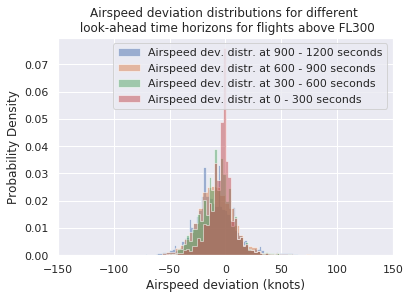

In [4]:
from matplotlib import mlab
fig, ax = plt.subplots(figsize=(6, 4))
range_lim = np.inf
dct = spd_dct_h

for i,la in enumerate(la_times[::-1]):

    la_lst = la_times[::-1] + [0]
    xtst = [x for x in dct[str(la)]['vals'] if ~np.isnan(x) and abs(x) < range_lim][:330000]
#     print(len(xtst))
    n_bins = 100

    # plot the cumulative histogram
    n, bins, patches = ax.hist(xtst, n_bins, normed=1, histtype='stepfilled',
                               cumulative=False, label='Airspeed dev. distr. at %s - %s seconds' % (la_lst[i+1], la), alpha=0.5
                               
                            
                              )

plt.legend()#prop={'size': 10}
plt.xlim(-150,150)
# plt.ylim(0,100000)
plt.xlabel('Airspeed deviation (knots)')
plt.ylabel('Probability Density')
plt.title('Airspeed deviation distributions for different \n look-ahead time horizons for flights above FL300')
plt.show()

/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


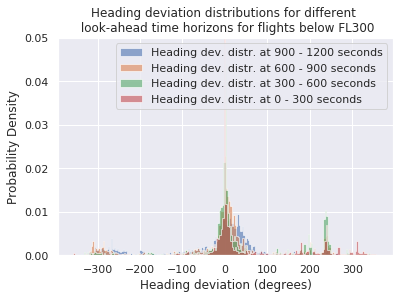

In [60]:
fig, ax = plt.subplots(figsize=(6,4))
range_lim = np.inf
dct = hdg_dct_l

for i,la in enumerate(la_times[::-1]):

    la_lst = la_times[::-1] + [0]
    xtst = [x for x in dct[str(la)]['vals'] if ~np.isnan(x) and abs(x) < range_lim][:330000]
    n_bins = 200

    # plot the cumulative histogram
    n, bins, patches = ax.hist(xtst, n_bins, normed=1, histtype='stepfilled',
                               cumulative=False, label='Heading dev. distr. at %s - %s seconds' % (la_lst[i+1], la), alpha=0.6)

plt.legend()
# plt.xlim(-150,200)
plt.ylim(0,0.05)
plt.xlabel('Heading deviation (degrees)')
plt.ylabel('Probability Density')
plt.title('Heading deviation distributions for different \n look-ahead time horizons for flights below FL300')
plt.show()

/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


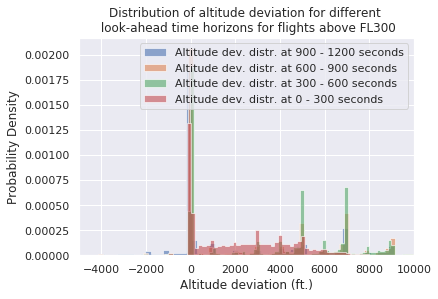

In [67]:
from matplotlib import mlab
fig, ax = plt.subplots(figsize=(6, 4))
range_lim = np.inf
dct = alt_dct_h

for i,la in enumerate(la_times[::-1]):

    la_lst = la_times[::-1] + [0]
    xtst = [x for x in dct[str(la)]['vals'] if ~np.isnan(x) and abs(x) < range_lim][:330000]
    n_bins = 100

    # plot the cumulative histogram
    n, bins, patches = ax.hist(xtst, n_bins, normed=1, histtype='stepfilled',
                               cumulative=False, label='Altitude dev. distr. at %s - %s seconds' % (la_lst[i+1], la), alpha=0.6)

plt.legend()
plt.xlim(-5000,10000)
# plt.ylim(-5000,10000)
plt.xlabel('Altitude deviation (ft.)')
plt.ylabel('Probability Density')
plt.title('Distribution of altitude deviation for different \n look-ahead time horizons for flights above FL300')
plt.show()

In [68]:
print('High Altitude')

for k in [('mean', 'Mean'),('var','Variance'),('kurt','Kurtosis'),('skew','Skewness')]:
#     print(k)
    val_str = '\multicolumn{1}{|l|}{%s}' % k[1]
    for v in alt_dct_h.keys():
        val_str = val_str + ' & %.1f' % (round(alt_dct_h[v][k[0]],1))
    val_str = val_str + ' \\\ \hline'
    print(val_str)
    

print('Low Altitude')

for k in [('mean', 'Mean'),('var','Variance'),('kurt','Kurtosis'),('skew','Skewness')]:
#     print(k)
    val_str = '\multicolumn{1}{|l|}{%s}' % k[1]
    for v in alt_dct_l.keys():
        val_str = val_str + ' & %.1f' % (round(alt_dct_l[v][k[0]],1))
    val_str = val_str + ' \\\ \hline'
    print(val_str)

High Altitude
\multicolumn{1}{|l|}{Mean} & 2342.2 & 3467.6 & 2840.3 & 1908.3 \\ \hline
\multicolumn{1}{|l|}{Variance} & 2152.0 & 3274.1 & 3356.5 & 3263.8 \\ \hline
\multicolumn{1}{|l|}{Kurtosis} & -0.7 & -1.4 & -1.1 & -0.1 \\ \hline
\multicolumn{1}{|l|}{Skewness} & 0.5 & 0.2 & 0.6 & 0.7 \\ \hline
Low Altitude
\multicolumn{1}{|l|}{Mean} & 462.9 & -421.6 & -7647.2 & -14592.2 \\ \hline
\multicolumn{1}{|l|}{Variance} & 5585.2 & 13193.6 & 16348.0 & 16017.3 \\ \hline
\multicolumn{1}{|l|}{Kurtosis} & -0.4 & -1.4 & -0.7 & 0.4 \\ \hline
\multicolumn{1}{|l|}{Skewness} & 0.4 & 0.4 & 0.9 & 1.3 \\ \hline


In [69]:
print('High Altitude')

for k in [('mean', 'Mean'),('var','Variance'),('kurt','Kurtosis'),('skew','Skewness')]:
#     print(k)
    val_str = '\multicolumn{1}{|l|}{%s}' % k[1]
    for v in hdg_dct_h.keys():
        val_str = val_str + ' & %.1f' % (round(hdg_dct_h[v][k[0]],1))
    val_str = val_str + ' \\\ \hline'
    print(val_str)
    

print('Low Altitude')

for k in [('mean', 'Mean'),('var','Variance'),('kurt','Kurtosis'),('skew','Skewness')]:
#     print(k)
    val_str = '\multicolumn{1}{|l|}{%s}' % k[1]
    for v in hdg_dct_l.keys():
        val_str = val_str + ' & %.1f' % (round(hdg_dct_l[v][k[0]],1))
    val_str = val_str + ' \\\ \hline'
    print(val_str)

High Altitude
\multicolumn{1}{|l|}{Mean} & 0.8 & 4.6 & 8.0 & 9.2 \\ \hline
\multicolumn{1}{|l|}{Variance} & 25.4 & 36.1 & 47.2 & 57.1 \\ \hline
\multicolumn{1}{|l|}{Kurtosis} & 61.2 & 21.2 & 11.7 & 7.2 \\ \hline
\multicolumn{1}{|l|}{Skewness} & 0.8 & 2.5 & 1.6 & 0.9 \\ \hline
Low Altitude
\multicolumn{1}{|l|}{Mean} & 43.1 & 42.2 & 1.2 & -21.2 \\ \hline
\multicolumn{1}{|l|}{Variance} & 109.9 & 127.1 & 134.8 & 129.0 \\ \hline
\multicolumn{1}{|l|}{Kurtosis} & 1.4 & 0.6 & 0.8 & 0.4 \\ \hline
\multicolumn{1}{|l|}{Skewness} & 0.9 & 0.0 & -0.3 & -0.5 \\ \hline


In [70]:
print('High Altitude')

for k in [('mean', 'Mean'),('var','Variance'),('kurt','Kurtosis'),('skew','Skewness')]:
#     print(k)
    val_str = '\multicolumn{1}{|l|}{%s}' % k[1]
    for v in spd_dct_h.keys():
        val_str = val_str + ' & %.1f' % (round(spd_dct_h[v][k[0]],1))
    val_str = val_str + ' \\\ \hline'
    print(val_str)
    

print('Low Altitude')

for k in [('mean', 'Mean'),('var','Variance'),('kurt','Kurtosis'),('skew','Skewness')]:
#     print(k)
    val_str = '\multicolumn{1}{|l|}{%s}' % k[1]
    for v in spd_dct_l.keys():
        val_str = val_str + ' & %.1f' % (round(spd_dct_l[v][k[0]],1))
    val_str = val_str + ' \\\ \hline'
    print(val_str)

High Altitude
\multicolumn{1}{|l|}{Mean} & -3.5 & -7.1 & -8.1 & -9.2 \\ \hline
\multicolumn{1}{|l|}{Variance} & 12.3 & 16.1 & 18.0 & 20.4 \\ \hline
\multicolumn{1}{|l|}{Kurtosis} & 7.7 & 4.8 & 4.2 & 3.3 \\ \hline
\multicolumn{1}{|l|}{Skewness} & 0.5 & 1.0 & 0.9 & 0.9 \\ \hline
Low Altitude
\multicolumn{1}{|l|}{Mean} & 31.0 & 41.8 & -22.8 & -102.7 \\ \hline
\multicolumn{1}{|l|}{Variance} & 71.7 & 135.3 & 159.7 & 170.8 \\ \hline
\multicolumn{1}{|l|}{Kurtosis} & 0.2 & -1.2 & -0.2 & 1.4 \\ \hline
\multicolumn{1}{|l|}{Skewness} & 0.9 & 0.5 & 1.0 & 1.5 \\ \hline


In [ ]:
plt.figure(figsize=(20,8))
plt.plot(la_times, [hdg_dct[str(la)]['mean'] for la in la_times])
plt.plot(la_times, [hdg_dct[str(la)]['var'] for la in la_times])
# plt.plot(la_times, [alt_dct[str(la)]['skew'] for la in la_times])
# plt.plot(la_times, [alt_dct[str(la)]['kurt'] for la in la_times])
plt.legend(prop={'size': 16})
plt.show()

In [ ]:
box_data = []
dct = spd_dct

for la in la_times:
    box_data.append((la, [i for i in dct[str(la)]['vals'] if ~np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

x = range(len(box_data_2)+1)

plt.figure(figsize=(10,8))
plt.boxplot(box_data_2, showfliers=False, patch_artist=True, whis=[5,95], widths = 0.1)
plt.xticks(x, ['0','60','300', '600', '900', '1200'])
# plt.xticks(rotation=70)
# plt.xlabel('Look-ahead time (seconds)')
# plt.ylabel('ATE in meters')
# plt.title('Evolution of ATE over look-ahead time')
# plt.legend(prop={'size': 16})
# plt.xlim((0,600))
plt.show()

In [ ]:
df = pd.DataFrame()

df['spd'] = spd_dct['300']['vals']
df['alt'] = alt_dct['300']['vals']
df['hdg'] = hdg_dct['300']['vals']

spd_std = (df['spd']-np.mean(df['spd']))/np.std(df['spd'])
hdg_std = (df['hdg']-np.mean(df['hdg']))/np.std(df['hdg'])
alt_std = (df['alt']-np.mean(df['alt']))/np.std(df['alt'])

In [ ]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

max_inserts = 100
fetch_batch_size = max_inserts
cnt = 0

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.projected_flights LIMIT 1000;")

fetch_batch_size = 1000

la_times = [5*x for x in range(1,121)]
alt_dct_2  = {}
spd_dct_2 = {}
hdg_dct_2 = {}

for la in la_times:
    alt_dct_2[str(la)] = []
    hdg_dct_2[str(la)] = []
    spd_dct_2[str(la)] = []

while True:
    
    batch = cur_read.fetchmany(size=fetch_batch_size)
    
    if not batch:
        break
    
    for f in batch:
        fdf = pd.DataFrame.from_dict(f)
        for i,la in enumerate(la_times):
            if i==0:
                alt_dct_2[str(la)].extend(fdf['alt'][(fdf['time_el'] <= la) & (fdf['time_el'] >= 0)].values - fdf['alt'][0])
                spd_dct_2[str(la)].extend(fdf['spd'][(fdf['time_el'] <= la) & (fdf['time_el'] >= 0)].values - fdf['spd'][0])
                hdg_dct_2[str(la)].extend(fdf['hdg'][(fdf['time_el'] <= la) & (fdf['time_el'] >= 0)].values - fdf['hdg'][0])
            else:
                alt_dct_2[str(la)].extend(fdf['alt'][(fdf['time_el'] <= la) & (fdf['time_el'] >= la_times[i-1])].values - fdf['alt'][0])
                spd_dct_2[str(la)].extend(fdf['spd'][(fdf['time_el'] <= la) & (fdf['time_el'] >= la_times[i-1])].values - fdf['spd'][0])
                hdg_dct_2[str(la)].extend(fdf['hdg'][(fdf['time_el'] <= la) & (fdf['time_el'] >= la_times[i-1])].values - fdf['hdg'][0])

cur_read.close()
conn.close()

In [ ]:
acf = []
acf_t = []
dct = hdg_dct_2
for i,la in enumerate(la_times):
    
    if i > 0:
        
        x = [v for v in dct[str(la_times[0])] if ~np.isnan(v)]
        y = [v for v in dct[str(la)] if ~np.isnan(v)]
        print(len(x))
        print(len(y))
        acf.append(est_cr(x,y))
        acf_t.append(la)

In [ ]:
x = [1,2,3,2,3,2,3,2,3]
n = len(x)
x = x-np.mean(x)
np.correlate(x,x, mode='full')[-n:]

In [ ]:
def est_acr(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return r

def est_cr(x,y):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = min(len(x),len(y))
    x = x[:n]
    y = y[:n]
    xstd = np.std(x)
    ystd = np.std(y)
    x = x-np.mean(x)
    y = y-np.mean(y)
    r = np.dot(x,y)/(n-1)
    result = r/(xstd*ystd)
    return result

In [ ]:
est_acr(x)

In [ ]:
est_cr([1,2,3,4,5,6],[3,4,3,4,3,4,5,5,5])

In [ ]:
x = [v for v in dct['50'] if ~np.isnan(v)]
y = [v for v in dct['60'] if ~np.isnan(v)]
print(len(x))
print(len(y))
acf.append(est_cr(x,y))